In [6]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%autoreload 2

import functools

from pymicro.file import file_utils
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics as met
from tqdm import tqdm

from tomo2seg.data import volume_precipitates_dryrun as volume_paths, ModelPaths
from tomo2seg.volume_img_segm import VolumeImgSegmSequence
from tomo2seg import viz

In [8]:
# get a distribution strategy to use both gpus
# see https://www.tensorflow.org/guide/distributed_training
mirrored_strategy = tf.distribute.MirroredStrategy()  # todo add strategy to metadata

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [9]:
dimensions = (500, 500, 500)
dtype = "uint8"  # todo remove the cast inside the generator?

# prefill the function `HST_read`
_hst_read = functools.partial(
    file_utils.HST_read,
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=dtype,
    dims=dimensions,
    verbose=True,
)

hst_read = lambda x: _hst_read(str(x))

labels_list = [0, 1, 2]

class labels:
    matrix = 0
    fiber = 1
    hole = 2

In [10]:
val = VolumeImgSegmSequence(
    # get a 3d np array
    source_volume=hst_read(volume_paths.val_data_path),  
    label_volume=hst_read(volume_paths.val_labels_path),  
    labels=labels_list,  # the classes encodings
    axes=(2,),  # z-axis slices only
    batch_size=1,
    shuffle=False, 
    normalization_const=255,
    n_geometric_augmentations=0,  # only the original slices as is
#     crop_size=500,  # no crop, get the whole slice
    crop_size=224,  
)

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


In [11]:
val_volume = hst_read(volume_paths.val_data_path)
val_volume.shape

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


(500, 500, 500)

# Reference segmentation

## Train volume


## Validation volume

# Model

In [12]:
model_name = "dryrun-03"
model_paths = ModelPaths(model_name)

In [14]:
with mirrored_strategy.scope():
    model = tf.keras.models.load_model(str(model_paths.autosaved_model_path) + ".hdf5")

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

# Predict

## Train

## Validation

In [15]:
val_pred = np.load("val-pred-probas.npy")

In [16]:
val_pred = np.load("val-pred-classes.npy")

# Examples

In [17]:
from skimage import data, segmentation
from skimage import filters
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

def plot_border(idx, generator, predictions):    
    img = generator[idx][0].reshape(224, 224)
    gt = val[idx][1].reshape(224, 224, 3).argmax(axis=2)
    pred = predictions[idx]

    gt_mask_fiber = gt == labels.fiber
    gt_mask_hole = gt == labels.hole
    
    gt_edges_fiber = segmentation.find_boundaries(gt_mask_fiber)
    gt_edges_fiber = np.ma.masked_where(~gt_edges_fiber, gt_edges_fiber)

    gt_edges_hole = segmentation.find_boundaries(gt_mask_hole)
    gt_edges_hole = np.ma.masked_where(~gt_edges_hole, gt_edges_hole)
    
    pred_mask_fiber = pred == labels.fiber
    pred_mask_hole = pred == labels.hole
    
    pred_edges_fiber = segmentation.find_boundaries(pred_mask_fiber)
    pred_edges_fiber = np.ma.masked_where(~pred_edges_fiber, pred_edges_fiber)

    pred_edges_hole = segmentation.find_boundaries(pred_mask_hole)
    pred_edges_hole = np.ma.masked_where(~pred_edges_hole, pred_edges_hole)

    sz = 10
    fig, axs = plt.subplots(2, 2, figsize=(sz, sz), dpi=200)
    fig.tight_layout()
    for ax in axs.ravel():
        ax.axis('off')
    
    # upper left
    axs[0, 0].imshow(img, cmap='gray', vmin=0, vmax=1)
    axs[0, 0].set_title("Image")
    
    # upper right
    axs[0, 1].imshow(img, cmap='gray', vmin=0, vmax=1)
    axs[0, 1].imshow(gt_edges_fiber, cmap=ListedColormap(['blue']), interpolation=None)
    axs[0, 1].imshow(gt_edges_hole, cmap=ListedColormap(['yellow']), interpolation=None)
    axs[0, 1].set_title("Ground truth")
    
    # bottom left
    axs[1, 0].imshow(img, cmap='gray', vmin=0, vmax=1)
    axs[1, 0].imshow(pred_edges_fiber, cmap=ListedColormap(['red']), interpolation=None)
    axs[1, 0].imshow(pred_edges_hole, cmap=ListedColormap(['magenta']), interpolation=None)
    axs[1, 0].set_title("Prediction")
    
    # bottom right
    axs[1, 1].imshow(img, cmap='gray', vmin=0, vmax=1)
    axs[1, 1].imshow(gt_edges_fiber, cmap=ListedColormap(['blue']), interpolation=None)
    axs[1, 1].imshow(gt_edges_hole, cmap=ListedColormap(['yellow']), interpolation=None)
    axs[1, 1].imshow(pred_edges_fiber, cmap=ListedColormap(['red']), interpolation=None)
    axs[1, 1].imshow(pred_edges_hole, cmap=ListedColormap(['magenta']), interpolation=None)
    axs[1, 1].set_title("Ground truth X Prediction")
    
    return fig, axs
 
    
plot_border_val = functools.partial(plot_border, generator=val, predictions=val_pred)  

In [18]:
def plot_pred(generator, predictions, idx, label):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    viz.show_slice(
        ax, 
        generator[idx][0].reshape(224, 224), 
        (~(predictions[idx] == label)).astype(int)
    )
    

def plot_label(generator, idx, label):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    viz.show_slice(
        ax, 
        generator[idx][0].reshape(224, 224), 
        (~(generator[idx][1].reshape(224, 224, 3).argmax(axis=2) == label)).astype(int)
    )

In [19]:
# plot_train_label = functools.partial(plot_label, generator=train)
# plot_train_pred = functools.partial(plot_pred, generator=train, predictions=train_pred)

plot_val_label = functools.partial(plot_label, generator=val)
plot_val_pred = functools.partial(plot_pred, generator=val, predictions=val_pred)

# Find some bad segmentations

## Image accuracy

In [20]:
accuracies = []
for idx in range(len(val)):
    truth = val[idx][1].reshape(224, 224, 3).argmax(axis=2)
    pred = val_pred[idx]

    accuracies.append(
        (truth == pred).sum() / (truth.shape[0] * truth.shape[1])
    )

In [21]:
accuracies_sort = np.argsort(accuracies)

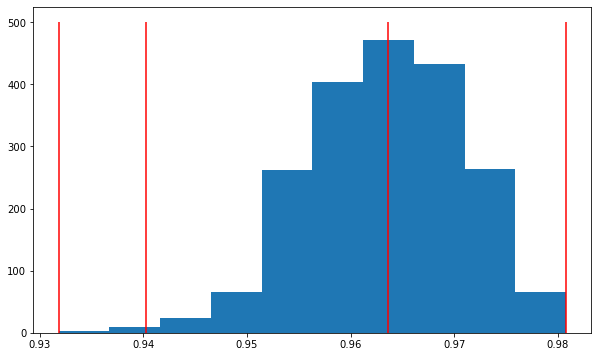

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(accuracies)
ax.vlines([accuracies[accuracies_sort[p]] for p in [0, 10, 1000, -1]], 0, 500, color='red')

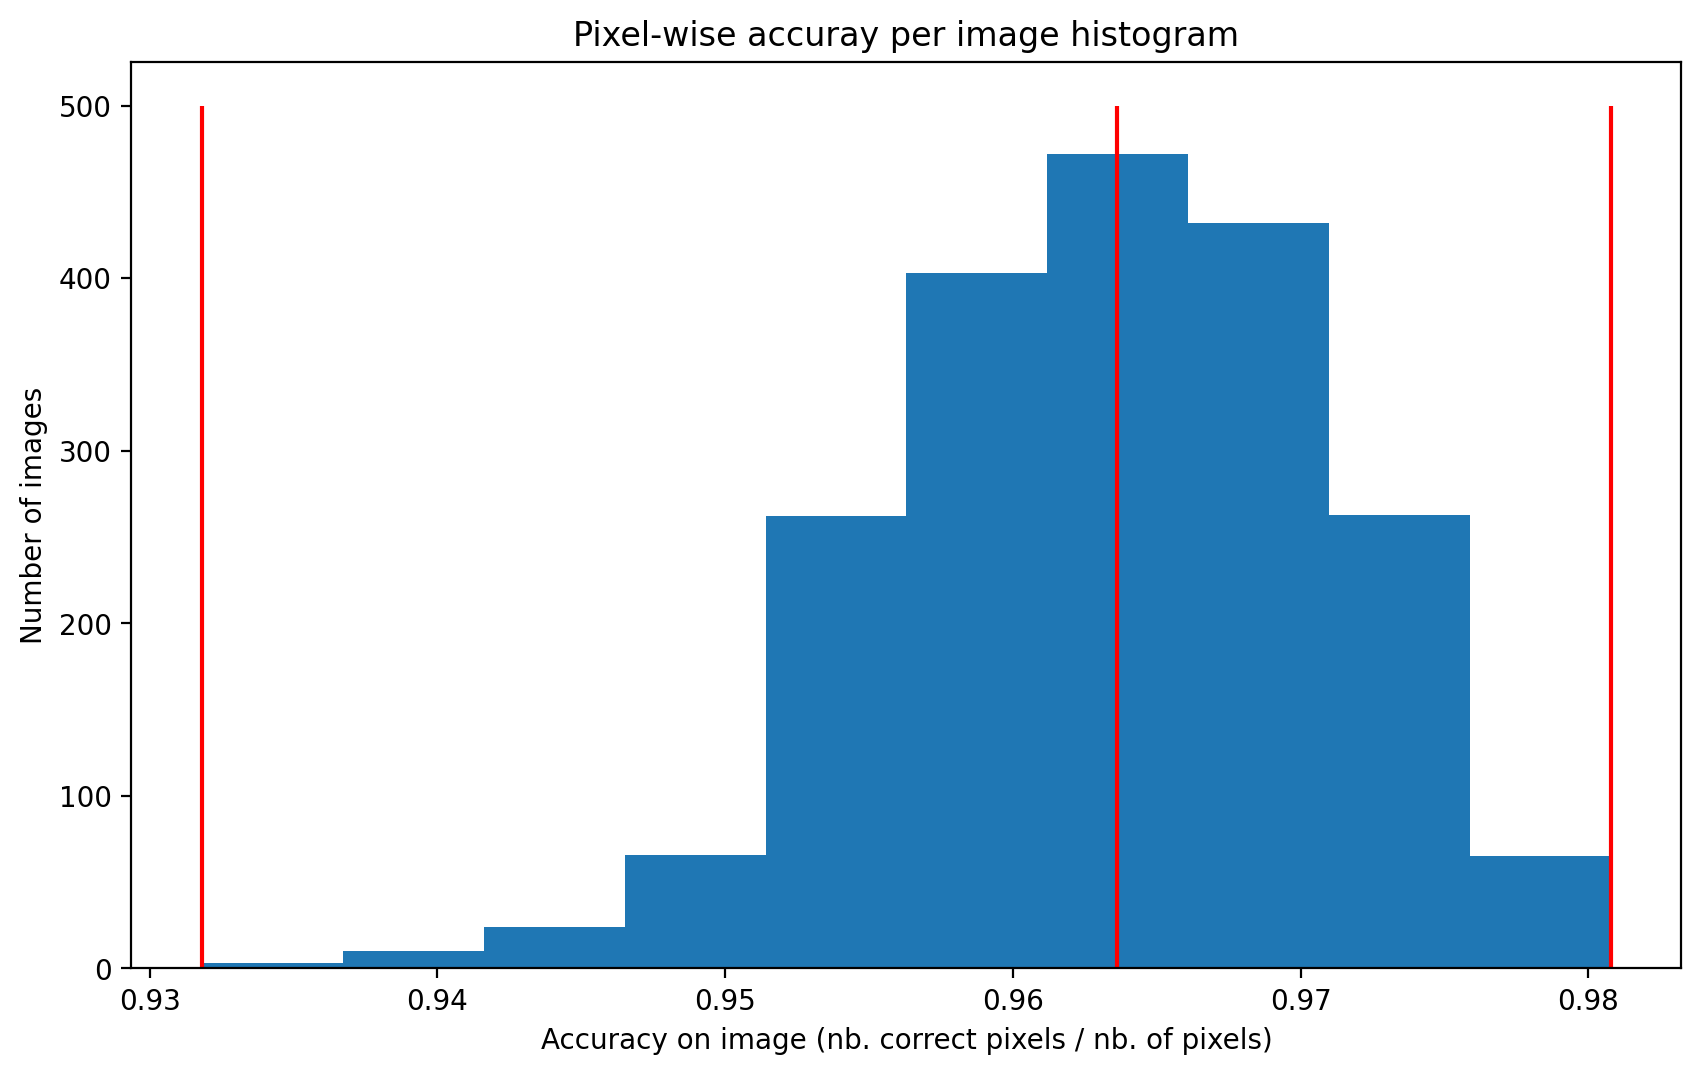

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=200)

ax.set_title("Pixel-wise accuray per image histogram")
ax.set_xlabel("Accuracy on image (nb. correct pixels / nb. of pixels)")
ax.set_ylabel("Number of images")
ax.hist(accuracies)
ax.vlines([accuracies[accuracies_sort[p]] for p in [0, 1000, -1]], 0, 500, color='red', ls='-')
fig.savefig(f"volume={volume_paths.volume_name}.set=validation.model={model_name}.image-accu-histogram.png")

Accuracy: 93.2%


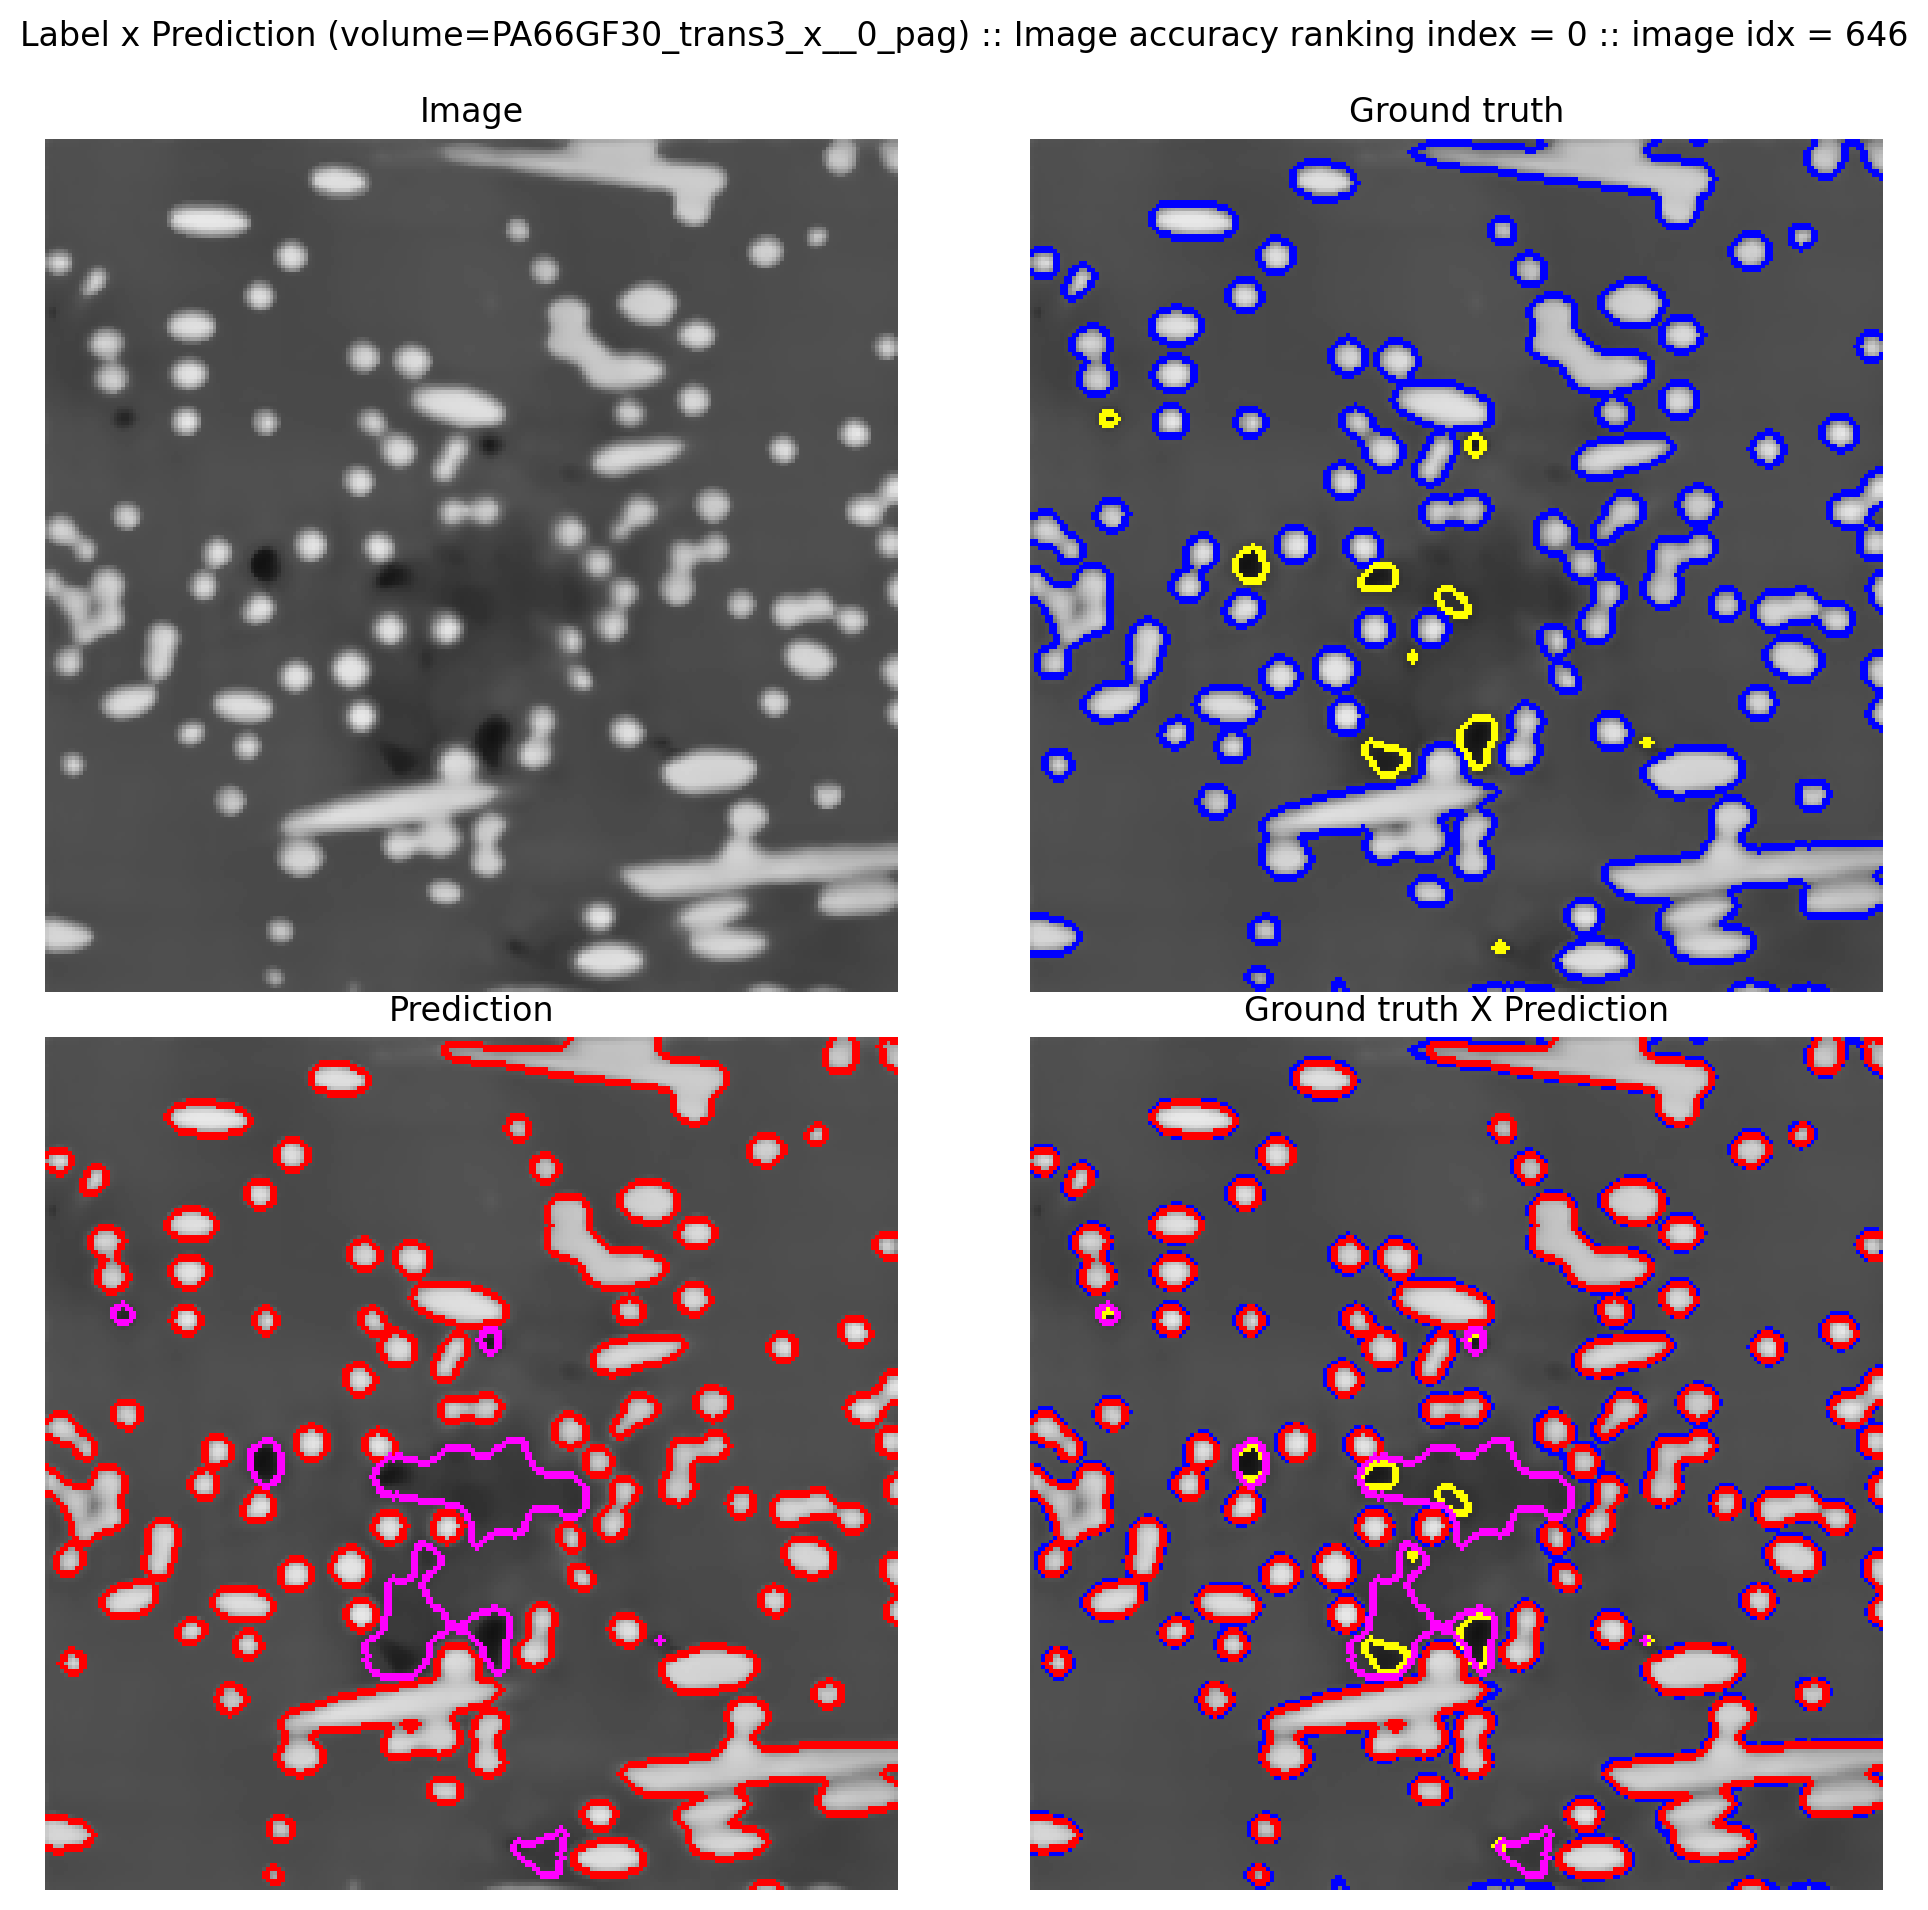

In [37]:
accu_idx = 0
idx = accuracies_sort[accu_idx]
accu = accuracies[idx]
print(f"Accuracy: {accu:.1%}")
fig, axs = plot_border_val(idx)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(f"Label x Prediction (volume={volume_paths.volume_name}) :: Image accuracy ranking index = {accu_idx} :: image idx = {idx}")
fig.savefig(f"volume={volume_paths.volume_name}.set=validation.model={model_name}.label-vs-pred.image_accuracy_sorted({accu_idx}).png")

Accuracy: 96.4%


/home/users/jcasagrande/projects/tomo2seg/condaenv/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/users/jcasagrande/projects/tomo2seg/condaenv/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/users/jcasagrande/projects/tomo2seg/condaenv/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/users/jcasagrande/projects/tomo2seg/condaenv/lib/python3.8/site-packages/matplotlib/image.py:477: UserWarning: Warning: converting a masked element to nan.
  vrange = np.array([self.norm.vmin, self.norm.vmax],


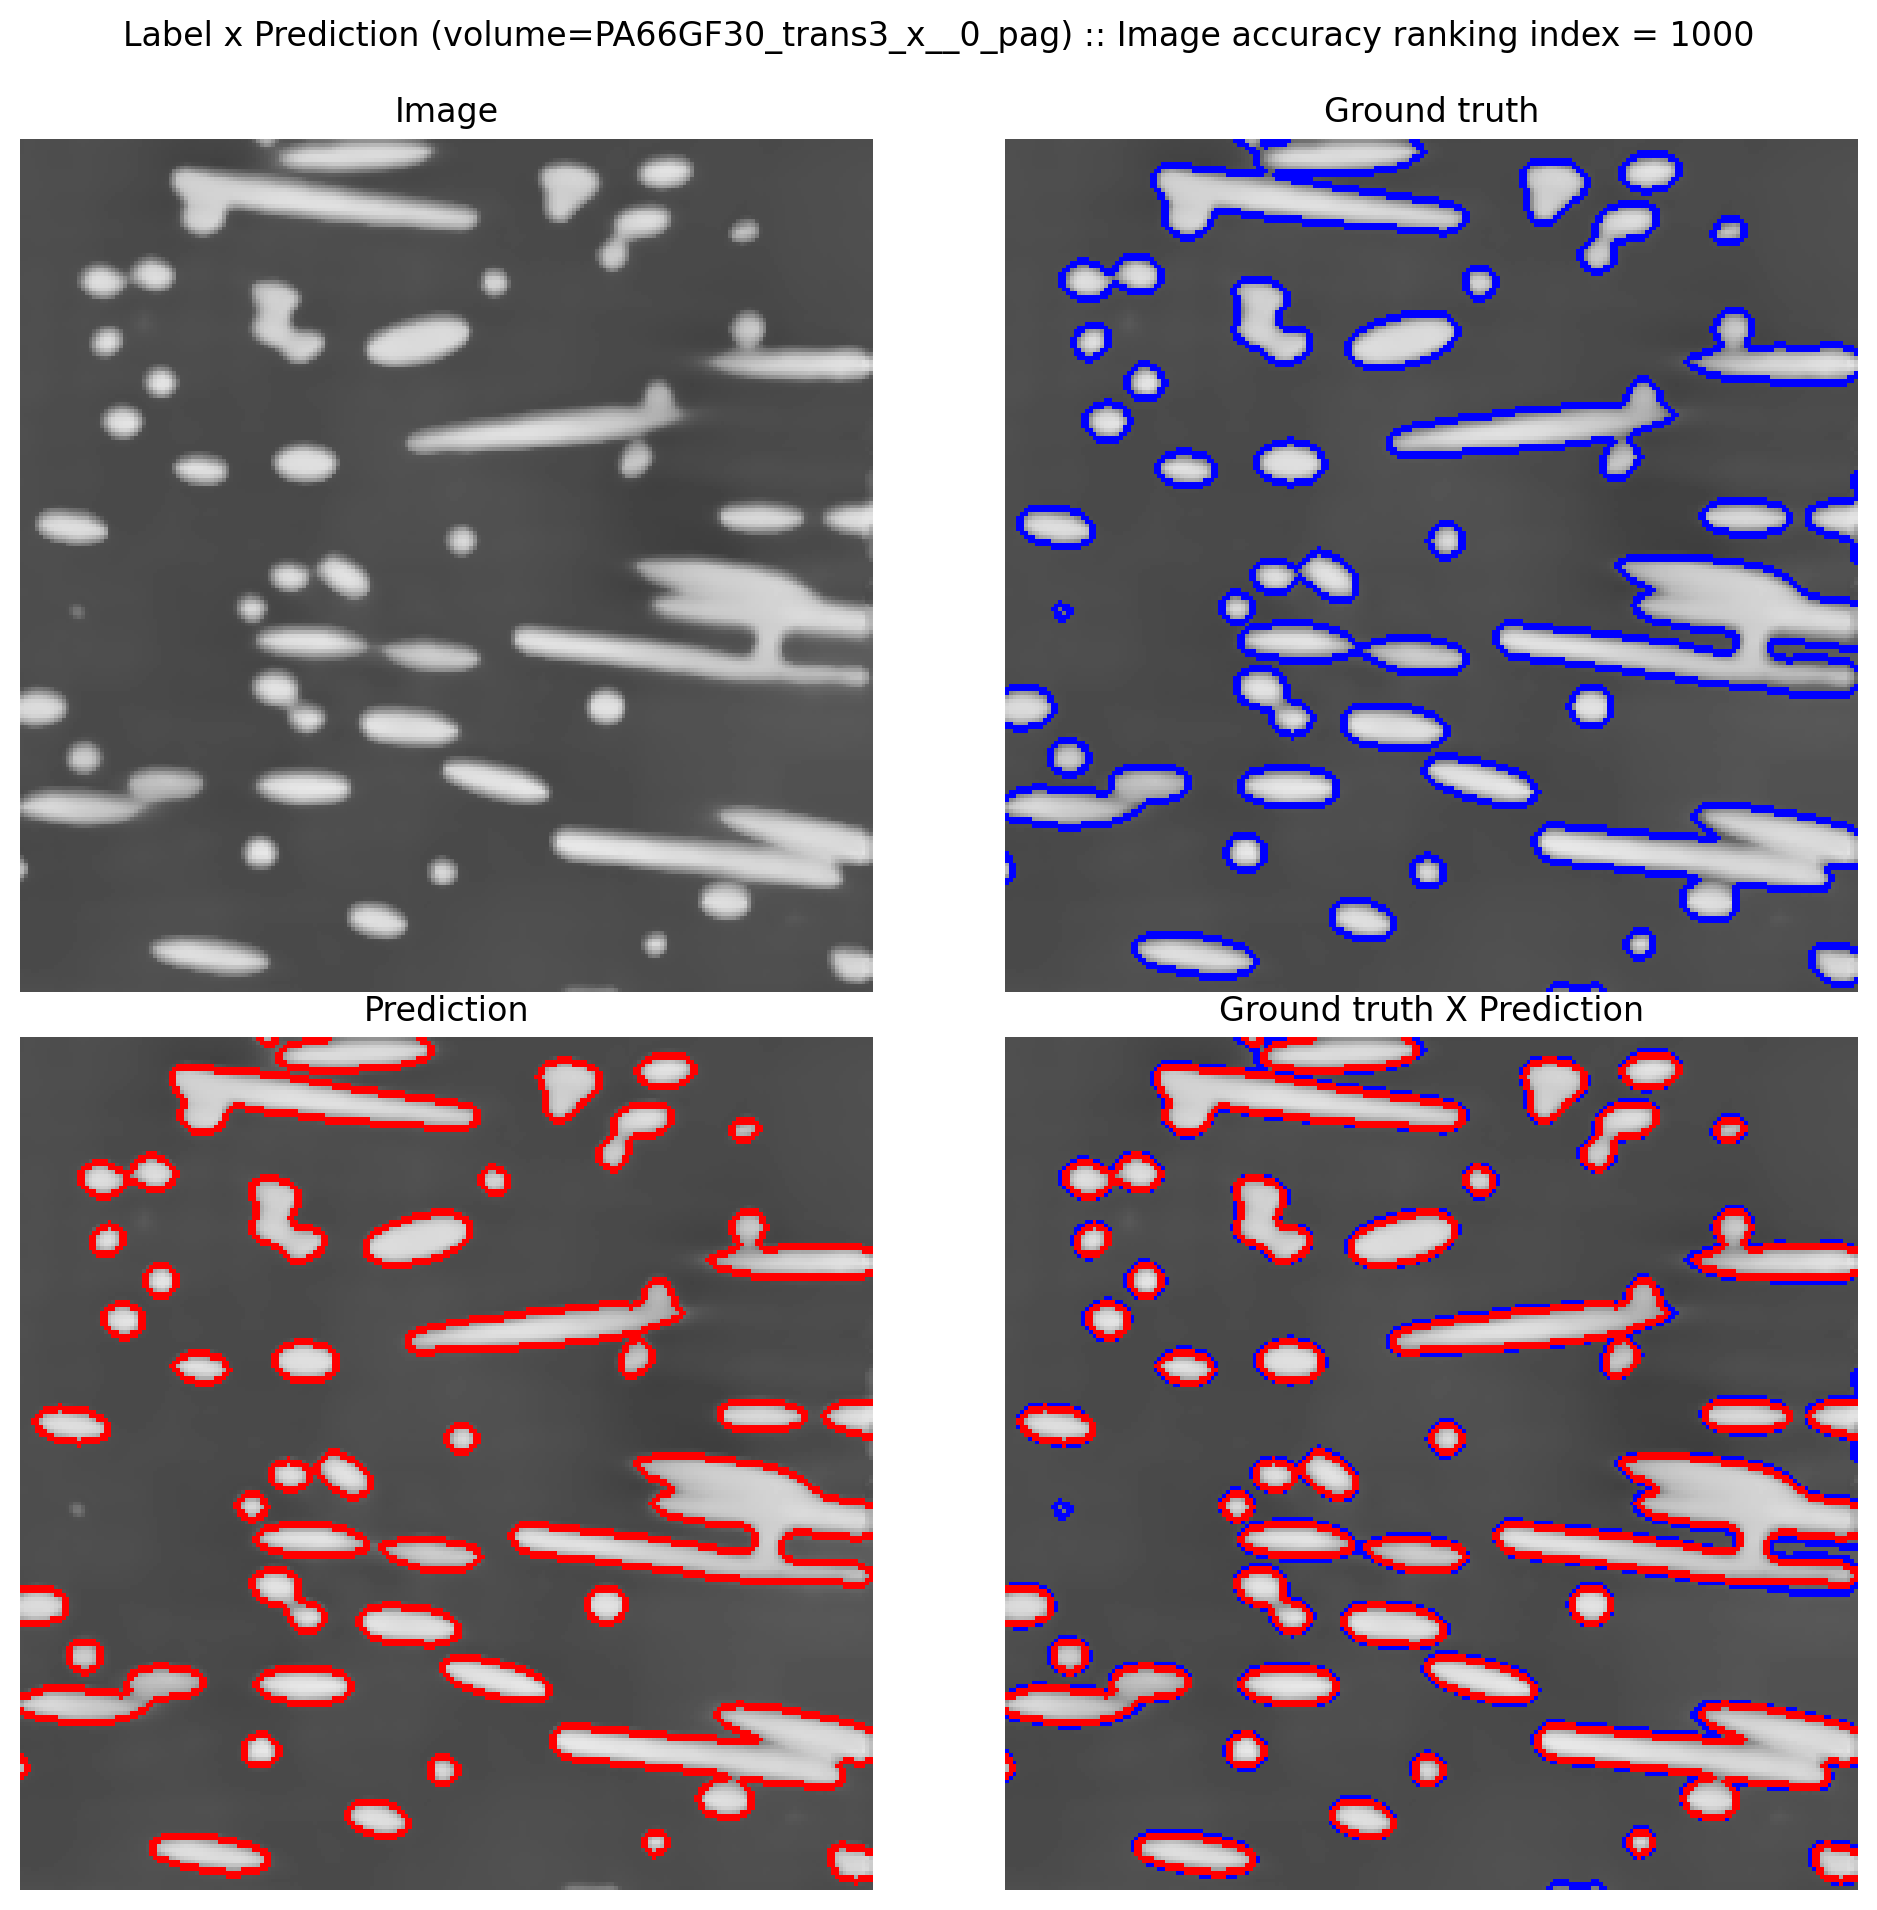

In [25]:
accu_idx = 1000
idx = accuracies_sort[accu_idx]
accu = accuracies[idx]
print(f"Accuracy: {accu:.1%}")
fig, axs = plot_border_val(idx)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(f"Label x Prediction (volume={volume_paths.volume_name}) :: Image accuracy ranking index = {accu_idx}")
fig.savefig(f"volume={volume_paths.volume_name}.set=validation.model={model_name}.label-vs-pred.image_accuracy_sorted({accu_idx}).png")

Accuracy: 98.1%


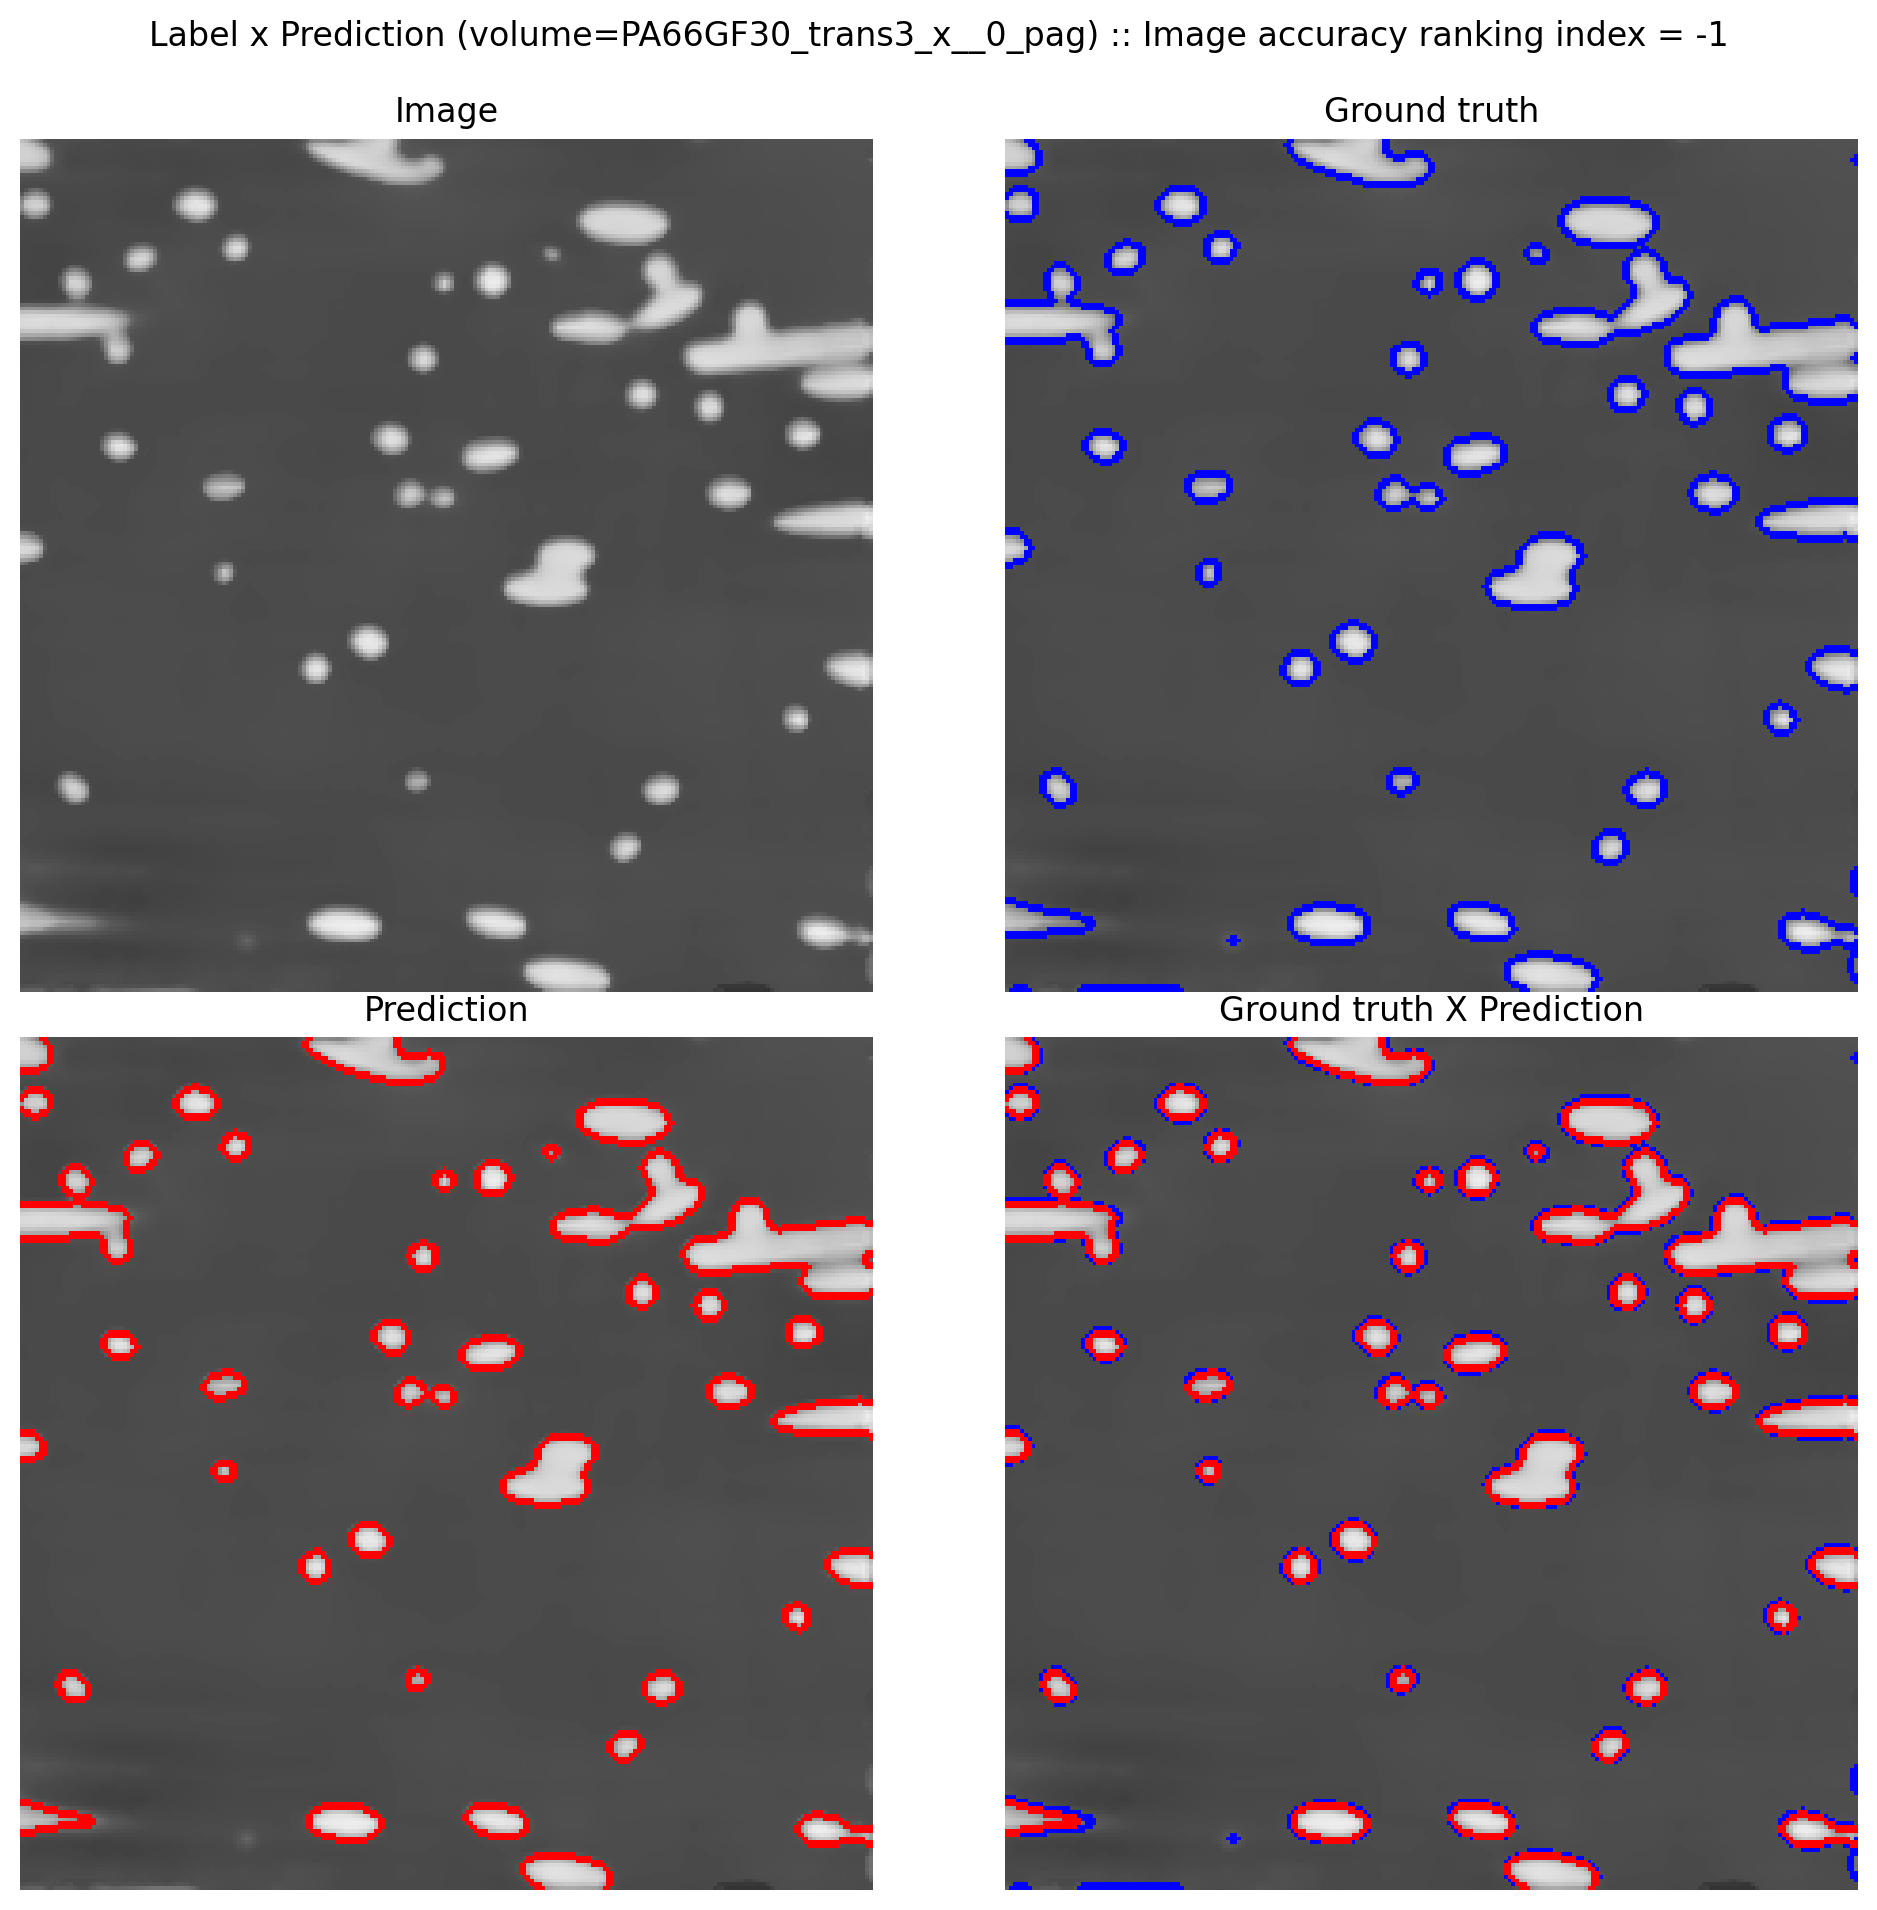

In [26]:
accu_idx = -1
idx = accuracies_sort[accu_idx]
accu = accuracies[idx]
print(f"Accuracy: {accu:.1%}")
fig, axs = plot_border_val(idx)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(f"Label x Prediction (volume={volume_paths.volume_name}) :: Image accuracy ranking index = {accu_idx}")
fig.savefig(f"volume={volume_paths.volume_name}.set=validation.model={model_name}.label-vs-pred.image_accuracy_sorted({accu_idx}).png")

## Cross entropy

In [27]:
val_pred_probas = np.load("val-pred-probas.npy")

In [28]:
losses = []
for idx in tqdm(range(len(val))):
    truth = val[idx][1].reshape(224, 224, 3).argmax().ravel()
    truth = val[idx][1].reshape(224, 224, 3).reshape(-1, 3)
    pred = val_pred_probas[idx].reshape(-1, 3)

    losses.append(met.log_loss(truth, pred))

100%|██████████| 2000/2000 [00:29<00:00, 67.56it/s]


In [29]:
losses_sort = np.argsort(losses)

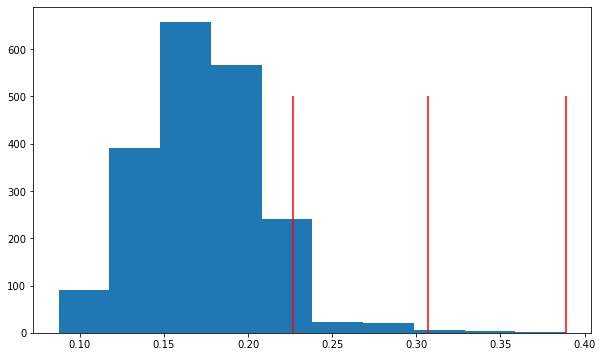

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(losses)
ax.vlines([losses[losses_sort[p]] for p in [-100, -10, -1]], 0, 500, color='red')

Loss: 0.39


(<Figure size 2000x2000 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'Image'}>,
         <AxesSubplot:title={'center':'Ground truth'}>],
        [<AxesSubplot:title={'center':'Prediction'}>,
         <AxesSubplot:title={'center':'Ground truth X Prediction'}>]],
       dtype=object))

/home/users/jcasagrande/projects/tomo2seg/condaenv/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/users/jcasagrande/projects/tomo2seg/condaenv/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/users/jcasagrande/projects/tomo2seg/condaenv/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/users/jcasagrande/projects/tomo2seg/condaenv/lib/python3.8/site-packages/matplotlib/image.py:477: UserWarning: Warning: converting a masked element to nan.
  vrange = np.array([self.norm.vmin, self.norm.vmax],


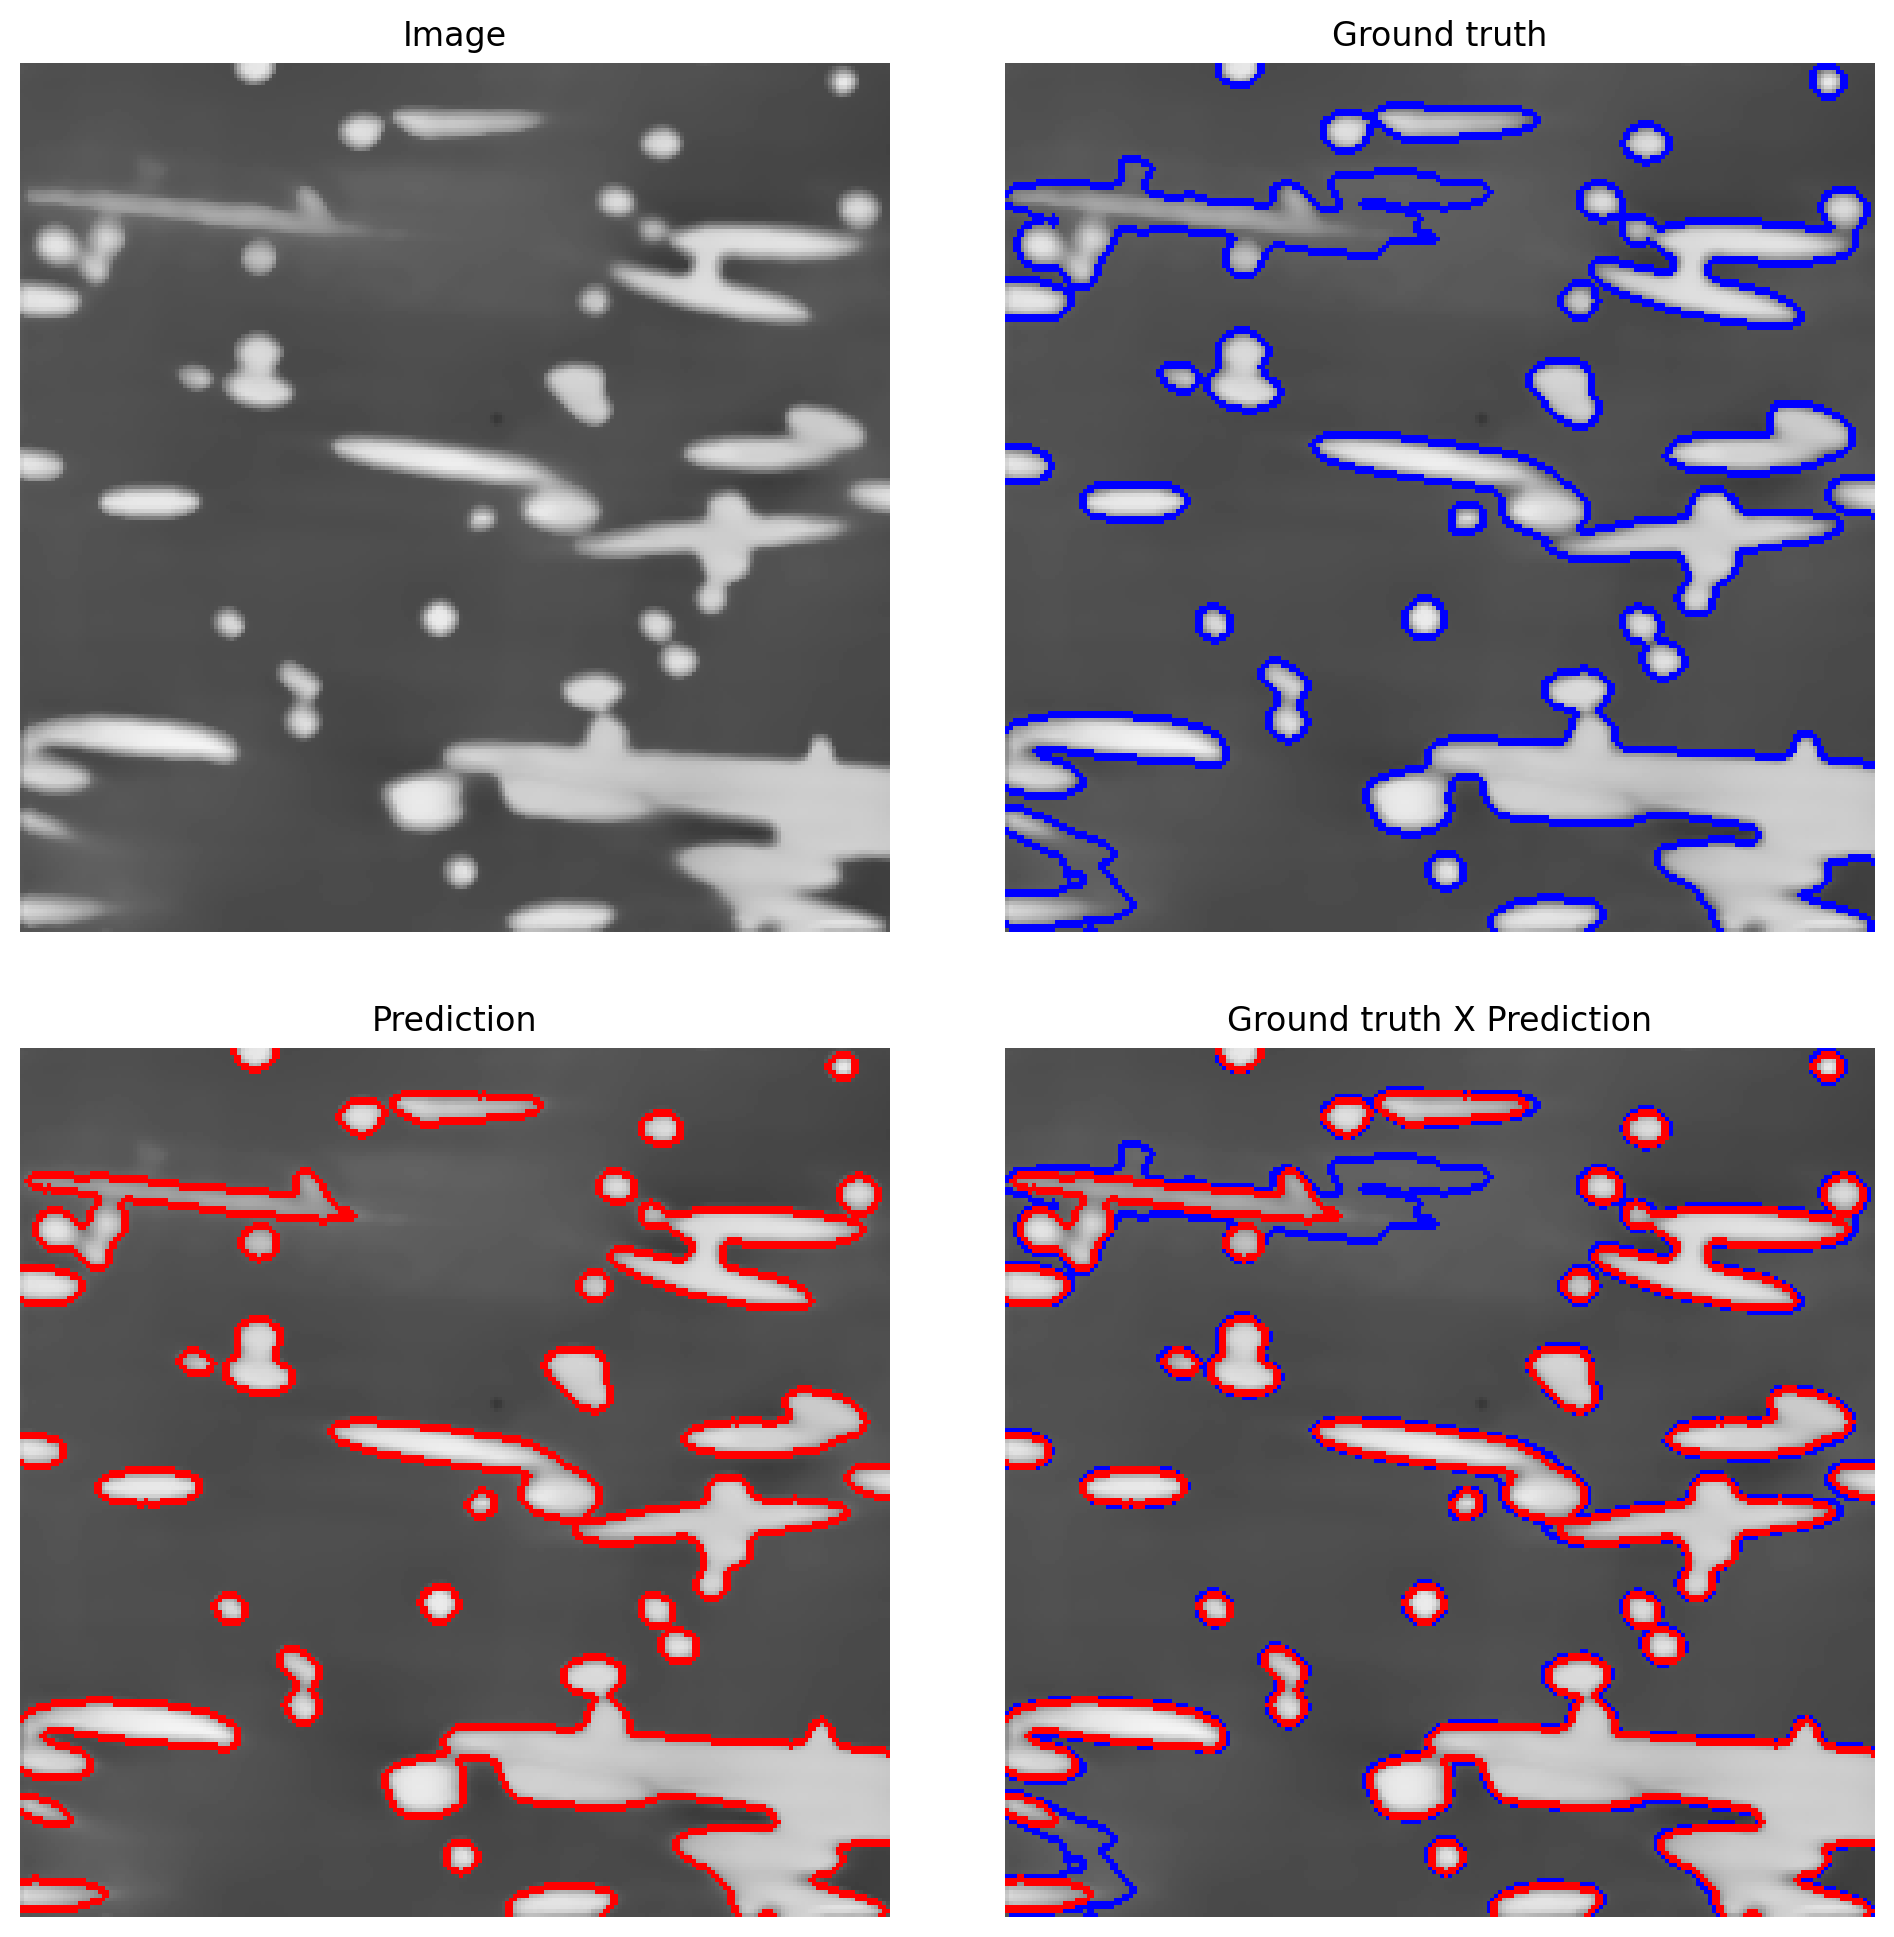

In [31]:
idx = losses_sort[-1]
loss = losses[idx]
print(f"Loss: {loss:.2f}")
plot_border_val(idx)

## Error blobs

In [32]:
idx = 0
generator = val
predictions = val_pred
img = generator[idx][0].reshape(224, 224)
gt = val[idx][1].reshape(224, 224, 3).argmax(axis=2)
pred = predictions[idx]

In [33]:
import skimage

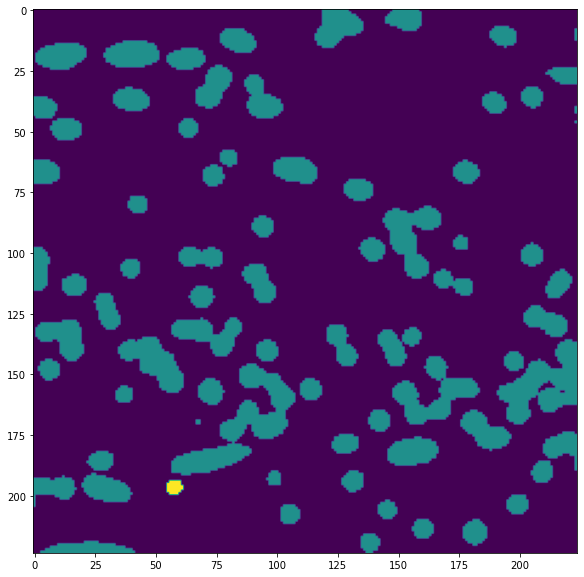

In [34]:
plt.figure(figsize=(10, 10))
plt.imshow(gt)

blobs, n_blobs = skimage.measure.label(gt, connectivity=2, return_num=True, background=0)

In [35]:
n_blobs

75

In [15]:
blob_stack = [(blobs == i).reshape(*blobs.shape, 1) for i in range(n_blobs + 1)]
blob_stack = np.concatenate(blob_stack, axis=2)

In [ ]:
blob